In [1]:
# Importar los datos en un dataframe
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
data = pd.read_csv('loan.csv',low_memory=False)
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Exploración de tipos de variables
d = pd.DataFrame(data.dtypes,columns=['Tipo'])
d.groupby('Tipo')['Tipo'].count()

Tipo
int64       2
float64    49
object     23
Name: Tipo, dtype: int64

In [5]:
# Explorar las etiquetas de clase
data['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [7]:
from datetime import datetime
def to_date(date_str):
    return datetime.strptime(date_str,'%Y%m%d')

# Se crea un dataframe copia de la data con el intervalo de fechas deseado
print(f'Data total: {data.count()[0]}')
print('Filtrando datos de jul-07 a dic-11')
data['issued'] = pd.to_datetime(data.issue_d)
data2 = pd.DataFrame(data.loc[lambda df: np.logical_and(to_date('20070701') <= df['issued'], df['issued']<=to_date('20111231'))])
print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
print('Eliminando registros inconsistentes o no aplicables para analisis.')
estados_eliminar = {'Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
for estado in estados_eliminar:
    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*(np.logical_or(np.logical_or((data2.loan_status=='Late (16-30 days)'),(data2.loan_status=='Late (31-120 days)')),(data2.loan_status=='In Grace Period'))) + 1*(np.logical_or((data2.loan_status=='Default'),(data2.loan_status=='Charged Off')))
print('Se crearon las clases.')

# Verificacion de los valores
print('Valores de la etiqueta de clase:')
print(data2['class'].value_counts())

Data total: 887379
Filtrando datos de jul-07 a dic-11
Data de jul-07 a dic-11: 42511
Eliminando registros inconsistentes o no aplicables para analisis.
Eliminado Issued. Quedan: 42511
Eliminado Does not meet the credit policy. Status:Charged Off. Quedan: 41753
Eliminado Does not meet the credit policy. Status:Fully Paid. Quedan: 39785
Eliminado Current. Quedan: 37825
Se crearon las clases.
Valores de la etiqueta de clase:
3    32150
1     5583
2       92
Name: class, dtype: int64


In [27]:
# NO EJECUTAR - GENERA EL OUTPUT CON ERROR
# SE GUARDA PARA VERSIONADO

#from datetime import datetime
#def to_date(date_str):
#    return datetime.strptime(date_str,'%Y%m%d')
    
# Se filtran los datos de julio 2007 a diciembre 2011
#print(f'Data original:{data.count()[0]}')
#print('Filtrando datos de jul-07 a dic-11')
#data['issued'] = pd.to_datetime(data.issue_d)
#data2 = data.where(lambda x: x.issued>=to_date('20070701')).where(lambda x: x.issued<=to_date('20111231'))
#print(f'Data de jul-07 a dic-11: {data2.count()[0]}')

# Se filtran los registros inconsistentes o no aplicables para analisis
# Current -> No aplicable porque son préstamos dentro de su periodo de pago.
# Does not meet the credit policy (...) -> Inconsistente. No se sabe si es un error o un valor correcto.
# Issued -> No aplicable porque son créditos recién emitidos.
# In grace period -> No aplicable porque son créditos en periodo de gracia.
#print('Eliminando registros inconsistentes o no aplicables para analisis.')
#estados_eliminar = {'In Grace Period','Current','Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off', 'Issued'}
#for estado in estados_eliminar:
#    data2.drop(data2[data2.loan_status==estado].index,inplace=True)
#    print(f'Eliminado {estado}. Quedan: {data2.count()[0]}')
    
# Se crean las clases
# 1: Default|Charged Off
# 2: Late (31-120 days)|Late (16-30 days)
# 3: Fully Paid
#data2['class'] = 3*(data2.loan_status=='Fully Paid') + 2*((data2.loan_status=='Late (16-30 days)') | (data2.loan_status=='Late (31-120 days)')) + 1*((data2.loan_status=='Default') | (data2.loan_status=='Charged Off'))
#print('Se crearon las clases.')

Data original:887379
Filtrando datos de jul-07 a dic-11
Data de jul-07 a dic-11: 42511
Eliminando registros inconsistentes o no aplicables para analisis.
Eliminado Does not meet the credit policy. Status:Charged Off. Quedan: 41753
Eliminado Issued. Quedan: 41753
Eliminado Does not meet the credit policy. Status:Fully Paid. Quedan: 39785
Eliminado Current. Quedan: 37825
Eliminado In Grace Period. Quedan: 37797
Se crearon las clases.


In [8]:
# Explorar la distribución de la etiqueta de clase
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    #aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum','contador':lambda x: int(sum(x)/data2.loc[x.index].loan_amnt.sum())}}
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_res=data2.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_res['id','porcentaje_cuenta'] = round(data_res['id','cuenta']/data_res['id'].sum()[0]*100,2)
data_res['loan_amnt','porcentaje_monto'] = round(data_res['loan_amnt','suma']/data_res['loan_amnt'].sum()[0]*100,2)
data_res.sort_index(axis=1)

id                          loan_amnt  \
                         cuenta porcentaje_cuenta porcentaje_monto   
class loan_status                                                    
1     Charged Off          5574             14.74            16.19   
      Default                 9              0.02             0.03   
2     In Grace Period        28              0.07             0.11   
      Late (16-30 days)      13              0.03             0.05   
      Late (31-120 days)     51              0.13             0.22   
3     Fully Paid          32150             85.00            83.41   

                                       
                                 suma  
class loan_status                      
1     Charged Off          67205600.0  
      Default                122000.0  
2     In Grace Period        448700.0  
      Late (16-30 days)      197600.0  
      Late (31-120 days)     903125.0  
3     Fully Paid          346213675.0

In [9]:
# Balanceo tomando 7000 registros de tipo Fully Paid y explorar el resultado final
n_rows_to_delete = data2[data2['class']==3].count()[0]-7000
data3 = data2.drop(data2[data2['class']==3].sample(n=n_rows_to_delete,random_state=40).index)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby(['class','loan_status'],as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1)

id                          loan_amnt            
                         cuenta porcentaje_cuenta porcentaje_monto        suma
class loan_status                                                             
1     Charged Off          5574             43.98            46.46  67205600.0
      Default                 9              0.07             0.08    122000.0
2     In Grace Period        28              0.22             0.31    448700.0
      Late (16-30 days)      13              0.10             0.14    197600.0
      Late (31-120 days)     51              0.40             0.62    903125.0
3     Fully Paid           7000             55.23            52.38  75767500.0

In [10]:
# Explorar el proposito de las deudas
with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=FutureWarning)
    aggregation_function = {'id':{'cuenta':'count'},'loan_amnt':{'suma':'sum'}}
    data_show=data3.groupby('purpose',as_index=True).agg(aggregation_function)
data_show['id','porcentaje_cuenta'] = round(data_show['id','cuenta']/data_show['id'].sum()[0]*100,2)
data_show['loan_amnt','porcentaje_monto'] = round(data_show['loan_amnt','suma']/data_show['loan_amnt'].sum()[0]*100,2)
data_show.sort_index(axis=1).sort_values(by=[('id','porcentaje_cuenta')],ascending=False)

id                          loan_amnt            
                   cuenta porcentaje_cuenta porcentaje_monto        suma
purpose                                                                 
debt_consolidation   5984             47.21            52.98  76637050.0
credit_card          1519             11.98            12.68  18334725.0
other                1322             10.43             7.61  11012675.0
home_improvement      925              7.30             7.25  10482800.0
small_business        740              5.84             7.15  10337725.0
major_purchase        609              4.80             3.61   5224475.0
car                   450              3.55             2.17   3132175.0
wedding               270              2.13             1.93   2789600.0
medical               237              1.87             1.36   1963650.0
moving                199              1.57             0.90   1297650.0
vacation              144              1.14             0.57    830275.0
house                 124              0.98             1.04   1500450.0
educational           115              0.91             0.57    821625.0
renewable_energy       37              0.29             0.19    279650.0

In [11]:
# Explorar los datos categóricos (no numéricos)
data3[data3.select_dtypes(include='object').columns.tolist()].head(3)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,Apr-1999,f,Apr-2013,NaN,Sep-2013,INDIVIDUAL,NaN
7,36 months,E,E1,MKC Accounting,9 years,RENT,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,Jan-2007,f,Jan-2015,NaN,Dec-2014,INDIVIDUAL,NaN
8,60 months,F,F2,NaN,4 years,OWN,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,Apr-2004,f,Apr-2012,NaN,Aug-2012,INDIVIDUAL,NaN


In [12]:
# Del resultado anterior, se observa que se puede procesar emp_length para que sea numerico
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['emp_length_str'] = data3['emp_length'].astype(str)
data3['emp_length_prc'] = data3['emp_length_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['emp_length_prc'] = data3['emp_length_prc'].astype(int)
data3.drop(columns='emp_length_str',inplace=True)
data3.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,issued,class,emp_length_prc
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,2.0,NaN,NaN,4.0,0.0,8221.0,87.5,4.0,f,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,Jan-2015,111.34,NaN,Dec-2014,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,3,9
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,Apr-2012,152.39,NaN,Aug-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,4


In [13]:
# Tambien se observa que se puede procesar manualmente la columna term_str para que sea numerica
import re

# Se crea una columna auxiliar para el procesamiento. Se extrae usando expresiones regulares, se convierte a entero 
# y finalmente se elimina la columna auxiliar
data3['term_str'] = data3['term'].astype(str)
data3['term_prc'] = data3['term_str'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x)!=[] else 0)
data3['term_prc'] = data3['term_prc'].astype(int)
data3.drop(columns='term_str',inplace=True)
data3.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,issued,class,emp_length_prc,term_prc
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,60
7,1072053,1288686,3000.0,3000.0,3000.0,36 months,18.64,109.43,E,E1,MKC Accounting,9 years,RENT,48000.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,5.35,0.0,Jan-2007,2.0,NaN,NaN,4.0,0.0,8221.0,87.5,4.0,f,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,Jan-2015,111.34,NaN,Dec-2014,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,3,9,36
8,1071795,1306957,5600.0,5600.0,5600.0,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I own a small h...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,Apr-2012,152.39,NaN,Aug-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,4,60
9,1071570,1306721,5375.0,5375.0,5350.0,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.0,Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/16/11 > I'm trying to b...,other,Building my credit history.,774xx,TX,18.08,0.0,Sep-2004,0.0,NaN,NaN,2.0,0.0,9279.0,36.5,3.0,f,0.0,0.0,1476.190000,1469.34,673.48,533.42,0.0,269.29,2.52,Nov-2012,121.45,NaN,Mar-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,60
12,1064687,1298717,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,Va. Dept of Conservation/Recreation,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/15/11 > Plan to pay off...,debt_consolidation,freedom,245xx,VA,10.08,0.0,Apr-2004,1.0,NaN,NaN,4.0,0.0,10452.0,91.7,9.0,f,0.0,0.0,2270.700000,2270.70,1256.14,570.26,0.0,444.30,4.16,Jul-2012,305.38,NaN,Nov-2012,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-01,1,1,36


In [14]:
# Eliminar columnas de id
id_lst=list(map(lambda x: 'id' in x,data3.columns))
id_column_name_lst = list(data3.columns[id_lst])
print(f'Numero de columnas original: {len(data3.columns.tolist())}')
data_clear = data3.drop(columns=id_column_name_lst, axis=1)
print(f'Numero de columnas filtrado: {len(data_clear.columns.tolist())}')

# Eliminar manualmente columnas de fechas, los campos originales que fueron procesados manualmente 
# y otras que carecen de relevancia
columnas_eliminar = ['url','earliest_cr_line','zip_code','last_credit_pull_d',
                     'issue_d','last_pymnt_d','next_pymnt_d','issued','term','emp_length','loan_status']
data_clear.drop(columns=columnas_eliminar,inplace=True)

# Codificar campos categóricos
print(f'Codificando campos categoricos')
cat_cols = data_clear.select_dtypes(include='object').columns.tolist()
cat_dict = dict()
for col in cat_cols:
    data_clear[col] = data_clear[col].astype('category')
    cat_dict[col] = {i+1:c for i,c in enumerate(data_clear[col].cat.categories)}
    data_clear[col] = data_clear[col].cat.codes+1
print('Campos categoricos codificados.')

Numero de columnas original: 78
Numero de columnas filtrado: 76
Codificando campos categoricos
Campos categoricos codificados.


In [15]:
# Se eliminan las columnas con mas de 100% de sus valores perdidos (nulos)
print('Eliminando columnas con mas de 100% de valores perdidos...')
print(f'Cantidad de columnas originales: {data_clear.shape[1]}')
cols_elim = [x for x in data_clear.columns if ((x!='mths_since_last_delinq') & (data_clear[x].isnull().sum()==data_clear.count().max()))]
print(f'Cantidad de columnas a eliminar: {len(cols_elim)}')
data_clear.drop(columns=cols_elim,axis=1,inplace=True)
print(f'Cantidad de columnas finales: {data_clear.shape[1]}')

Eliminando columnas con mas de 100% de valores perdidos...
Cantidad de columnas originales: 65
Cantidad de columnas a eliminar: 20
Cantidad de columnas finales: 45


In [16]:
# https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
# Llenar valores vacios con media
from sklearn.preprocessing import Imputer 
imp = Imputer(missing_values='NaN',strategy='median',axis=0,verbose=10)
imp.fit(data_clear)
data_clear_f = imp.transform(data_clear)
print(f'Llenando los vacios con el valor de la mediana.')
# data_clear_f = data_clear.fillna(value=data_clear.median())

Llenando los vacios con el valor de la mediana.


In [18]:
data_clear_f2 = pd.DataFrame(data=data_clear_f,columns=data_clear.columns)
print(f'Presencia de nulos: {np.any(data_clear_f2.isnull())}')
data_clear_f2.head()

Presencia de nulos: False


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,home_ownership,annual_inc,verification_status,pymnt_plan,desc,purpose,title,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,verification_status_joint,acc_now_delinq,class,emp_length_prc,term_prc
0,2500.0,2500.0,2500.0,15.27,59.83,3.0,14.0,6706.0,5.0,30000.0,2.0,1.0,6400.0,1.0,5653.0,11.0,1.00,0.0,5.0,34.0,91.0,3.0,0.0,1687.0,9.4,4.0,1.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,0.0,1.0,1.0,0.0,0.0,1.0,1.0,60.0
1,3000.0,3000.0,3000.0,18.64,109.43,5.0,21.0,4833.0,5.0,48000.0,2.0,1.0,6321.0,1.0,802.0,5.0,5.35,0.0,2.0,34.0,91.0,4.0,0.0,8221.0,87.5,4.0,1.0,0.0,0.0,3938.144334,3938.14,3000.00,938.14,0.0,0.00,0.00,111.34,0.0,1.0,1.0,0.0,0.0,3.0,9.0,36.0
2,5600.0,5600.0,5600.0,21.28,152.39,6.0,27.0,0.0,4.0,40000.0,2.0,1.0,6384.0,12.0,2051.0,5.0,5.55,0.0,2.0,34.0,91.0,11.0,0.0,5210.0,32.6,13.0,1.0,0.0,0.0,646.020000,646.02,162.02,294.94,0.0,189.06,2.09,152.39,0.0,1.0,1.0,0.0,0.0,1.0,4.0,60.0
3,5375.0,5375.0,5350.0,12.69,121.45,2.0,10.0,7361.0,5.0,15000.0,3.0,1.0,6324.0,10.0,598.0,43.0,18.08,0.0,0.0,34.0,91.0,2.0,0.0,9279.0,36.5,3.0,1.0,0.0,0.0,1476.190000,1469.34,673.48,533.42,0.0,269.29,2.52,121.45,0.0,1.0,1.0,0.0,0.0,1.0,1.0,60.0
4,9000.0,9000.0,9000.0,13.49,305.38,3.0,11.0,8451.0,5.0,30000.0,2.0,1.0,6304.0,3.0,6102.0,45.0,10.08,0.0,1.0,34.0,91.0,4.0,0.0,10452.0,91.7,9.0,1.0,0.0,0.0,2270.700000,2270.70,1256.14,570.26,0.0,444.30,4.16,305.38,0.0,1.0,1.0,0.0,0.0,1.0,1.0,36.0


# Selección de características

### Primer analisis

In [32]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = data_clear_f2[data_clear_f2.drop(columns='class',axis=1).columns.tolist()]
y = data_clear_f2['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

El set de entrenamiento/validacion tiene 10140 muestras.
El set de pruebas tiene 2535 muestras.


Los autores usan Random Forest para determinar las características más relevantes. Sin embargo, no indican los hiperparámetros utilizados para el entrenamiento, por lo que se asume que se toman los valores predeterminados.

In [89]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(X_trainval):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    RF = RandomForestClassifier(n_estimators=10)
    RF = RF.fit(X_train,y_train)
    classifiers_lst.append(RF)
    y_pred = RF.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
# avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
# best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
best_class = sorted(zip(scores_lst,classifiers_lst),key=(lambda x:x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     2 ... 10136 10137 10138] TEST: [    7    14    38 ... 10120 10135 10139]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   26    28    42 ... 10106 10116 10131]
TRAIN: [    0     1     2 ... 10136 10137 10139] TEST: [    4     8    11 ... 10110 10129 10138]
TRAIN: [    1     2     3 ... 10137 10138 10139] TEST: [    0    21    25 ... 10108 10128 10136]
TRAIN: [    0     2     3 ... 10136 10138 10139] TEST: [    1     5     6 ... 10104 10113 10137]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    3    15    24 ... 10132 10133 10134]
TRAIN: [    0     1     3 ... 10137 10138 10139] TEST: [    2     9    37 ... 10084 10092 10115]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   16    18    48 ... 10118 10122 10124]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   39    44    46 ... 10119 10125 10126]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   10    12    17 ... 10123 10127 10130]


In [34]:
# Se recuperan los features más importantes
# feature_vector_importance =[list(x) for x in sorted(zip(X_trainval.columns,best_class[1].feature_importances_),key=(lambda x:x[1]),reverse=True)][0:15]
feature_vector_importance = pd.DataFrame({'feature':X_trainval.columns.tolist(),
                                          'importance':best_class[1].feature_importances_.tolist()})
feature_vector_importance.sort_values(by='importance',kind='quicksort',ascending=False).reset_index(drop=True)['feature'][0:25]

0     collection_recovery_fee
1             total_rec_prncp
2                  recoveries
3                   loan_amnt
4                 funded_amnt
5             total_pymnt_inv
6                 installment
7                   out_prncp
8             last_pymnt_amnt
9             funded_amnt_inv
10                total_pymnt
11              out_prncp_inv
12                   term_prc
13              total_rec_int
14                  sub_grade
15         total_rec_late_fee
16                 revol_util
17                 annual_inc
18                  revol_bal
19                   int_rate
20                        dti
21                       desc
22                      title
23     mths_since_last_delinq
24        verification_status
Name: feature, dtype: object

Se utiliza un mapa de calor de la matriz de correlación para visualizar los atributos más correlacionados entre sí

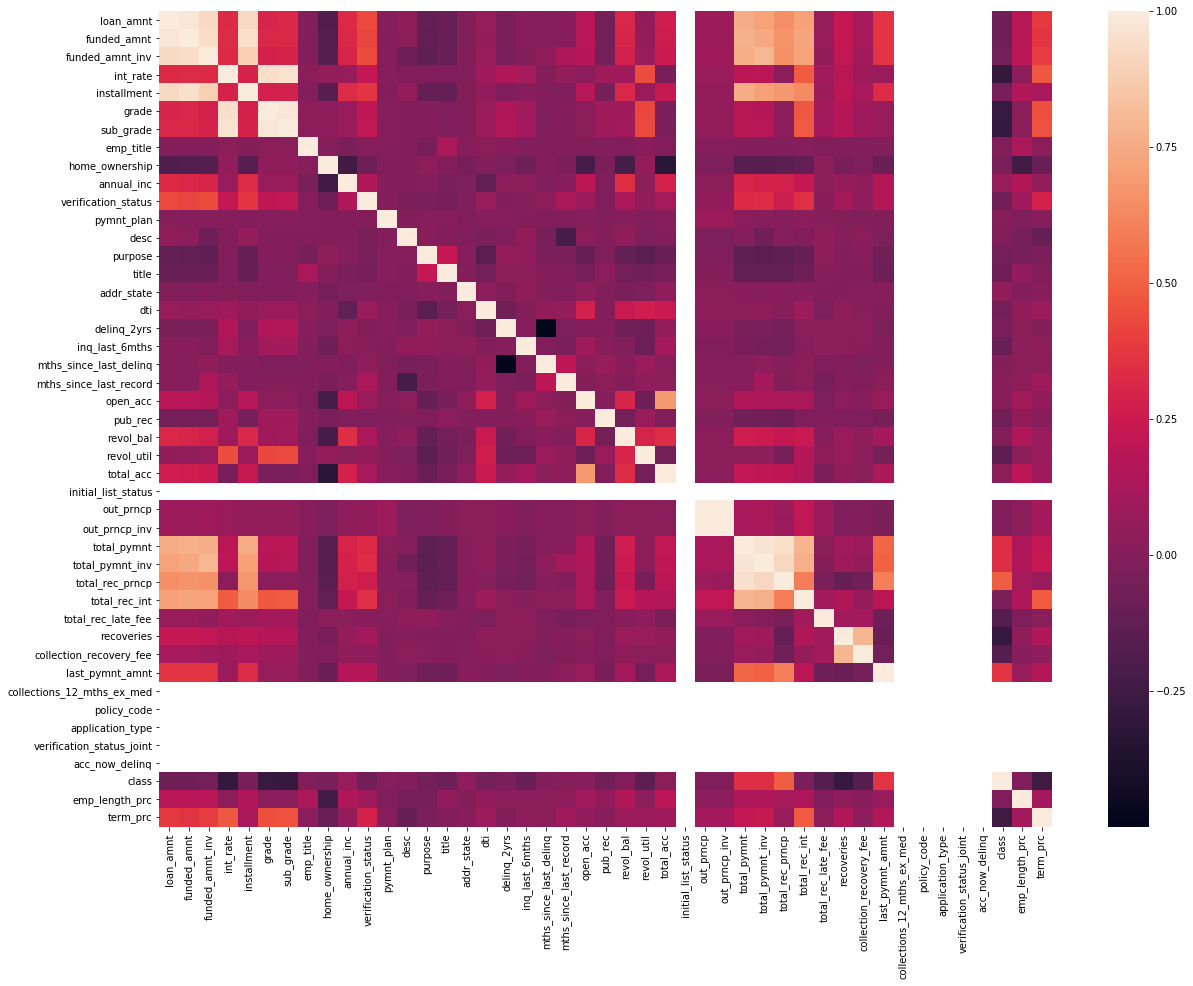

In [36]:
# Ayuda de: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# https://datascience.stackexchange.com/questions/17540/make-seaborn-heatmap-bigger

# Se analiza la correlación entre los elementos del vector de características
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_f2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Se compara lo obtenido por random forest vs el analisis de correlación para descartar variables:

collection_recovery_fee - x (Correlacion con recoveries) y tampoco tiene sentido para predecir si el cliente es nuevo
total_rec_prncp - x No tiene sentido para predecir si el cliente es nuevo
recoveries - x No tiene sentido para predecir si el cliente es nuevo
loan_amnt - 1
total_pymnt_inv - x No tiene sentido para predecir si el cliente es nuevo
installment - x (Correlacion con loan_amnt)
out_prncp - 2
last_pymnt_amnt - x No tiene sentido para predecir si el cliente es nuevo
term_prc (term) - 3
total_rec_int - x No tiene sentido para predecir si el cliente es nuevo
subgrade - 4
total_rec_late_fee - x No tiene sentido para predecir si el cliente es nuevo
revol_util - 5
annual_inc - 6
revol_bal - 7
int_rate - 8
dti - 9
desc - x No tiene sentido, es un campo de descripcion
title - 10 

Del analisis anterior se ve que hay demasiadas columnas que por reglas de negocio no deberían usarse para tratar de predecir un crédito. Se revisó el diccionario de datos y se eliminaron más columnas.

### Segundo analisis

En esta sección, se comparan todas las características vs el diccionario de datos para eliminar aquellas que no fueran aplicables al dominio del problema.

In [72]:
data_clear_f3.columns

Index(['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'grade',
       'sub_grade', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'verification_status_joint', 'acc_now_delinq',
       'class', 'emp_length_prc', 'term_prc'],
      dtype='object')

In [73]:
columnas_eliminar = {'desc', # desc es la descripcion del credito, puede tener cualquier valor
                     # Información de pagos no puede usarse para predecir un crédito
                     'total_pymnt', 
                     'total_pymnt_inv', 
                     'last_pymnt_amnt',
                     # Información de recuperación de inversión no puede usarse para predecir un crédito
                     'recoveries',  
                     'collection_recovery_fee',
                     'total_rec_prncp',
                     'total_rec_int',
                     'total_rec_late_fee',
                     # Información de saldo deudor no puede usarse para predicción de créditos
                     'out_prncp_inv',
                     'out_prncp',
                     # Información de nomenclaturas no tiene sentido en una predicción de préstamo
                     'title', # Nombre del préstamo asignado por el prestatario
                     'emp_title',# Nombre del trabajo asignado por el prestatario
                     'funded_amnt_inv', # Total de inversion de prestamistas hasta dicho momento en el tiempo. 
                                       # No tiene sentido su inclusión porque si se quiere predecir un nuevo préstamo
                                       # todavía no hay inversión alguna
                     'addr_state' # información geográfica no es un criterio financiero para evaluar a un solicitante
                     }
data_clear_f3 = data_clear_f2.drop(columns=columnas_eliminar)

X2 = data_clear_f3[data_clear_f3.drop(columns='class',axis=1).columns.tolist()]
y2 = data_clear_f3['class']

X_trainval, X_test, y_trainval, y_test = train_test_split(X2, y2, test_size=0.20, random_state=40)
print(f'El set de entrenamiento/validacion tiene {len(X_trainval)} muestras.')
print(f'El set de pruebas tiene {len(X_test)} muestras.')

El set de entrenamiento/validacion tiene 10140 muestras.
El set de pruebas tiene 2535 muestras.


In [74]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(X_trainval):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    #CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=10,min_samples_leaf=3,max_features=10)
    #CART = CART.fit(X_train,y_train)
    RF = RandomForestClassifier(n_estimators=10,max_depth=5,bootstrap=False,max_features=15)
    RF = RF.fit(X_train,y_train)
    classifiers_lst.append(RF)
    y_pred = RF.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
# avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
print(f'Accuracy promedio = {avg_score}')
# best_class = sorted(zip(scores_lst,classifiers_lst),key=f_first,reverse=True)[0]
best_class = sorted(zip(scores_lst,classifiers_lst),key=(lambda x:x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class[1].predict(X_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   12    22    34 ... 10118 10121 10133]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   20    30    45 ... 10117 10127 10132]
TRAIN: [    0     1     2 ... 10135 10138 10139] TEST: [    5    10    43 ... 10123 10136 10137]
TRAIN: [    0     1     2 ... 10136 10137 10138] TEST: [    9    24    32 ... 10116 10124 10139]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    7    14    19 ... 10114 10122 10126]
TRAIN: [    0     1     2 ... 10136 10137 10139] TEST: [    3    13    16 ... 10125 10131 10138]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    8    17    29 ... 10084 10090 10130]
TRAIN: [    1     2     3 ... 10137 10138 10139] TEST: [    0    36    41 ... 10108 10128 10129]
TRAIN: [    0     3     5 ... 10137 10138 10139] TEST: [    1     2     4 ... 10113 10120 10135]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    6    15    33 ... 10095 10102 10134]


In [75]:
# Se recuperan los 15 features más importantes
# feature_vector_importance =[list(x) for x in sorted(zip(X_trainval.columns,best_class[1].feature_importances_),key=(lambda x:x[1]),reverse=True)][0:15]
feature_vector_importance_2 = pd.DataFrame({'feature':X_trainval.columns.tolist(),
                                          'importance':best_class[1].feature_importances_.tolist()})
feature_vector_importance_2.sort_values(by='importance',kind='quicksort',ascending=False).reset_index(drop=True)['feature'][0:25]

0                       term_prc
1                       int_rate
2                      sub_grade
3                          grade
4                     annual_inc
5                        purpose
6                     revol_util
7                      revol_bal
8                            dti
9                      total_acc
10                   installment
11        mths_since_last_record
12                     loan_amnt
13                inq_last_6mths
14                emp_length_prc
15                   funded_amnt
16                       pub_rec
17        mths_since_last_delinq
18                      open_acc
19           verification_status
20                   delinq_2yrs
21                home_ownership
22                    pymnt_plan
23           initial_list_status
24    collections_12_mths_ex_med
Name: feature, dtype: object

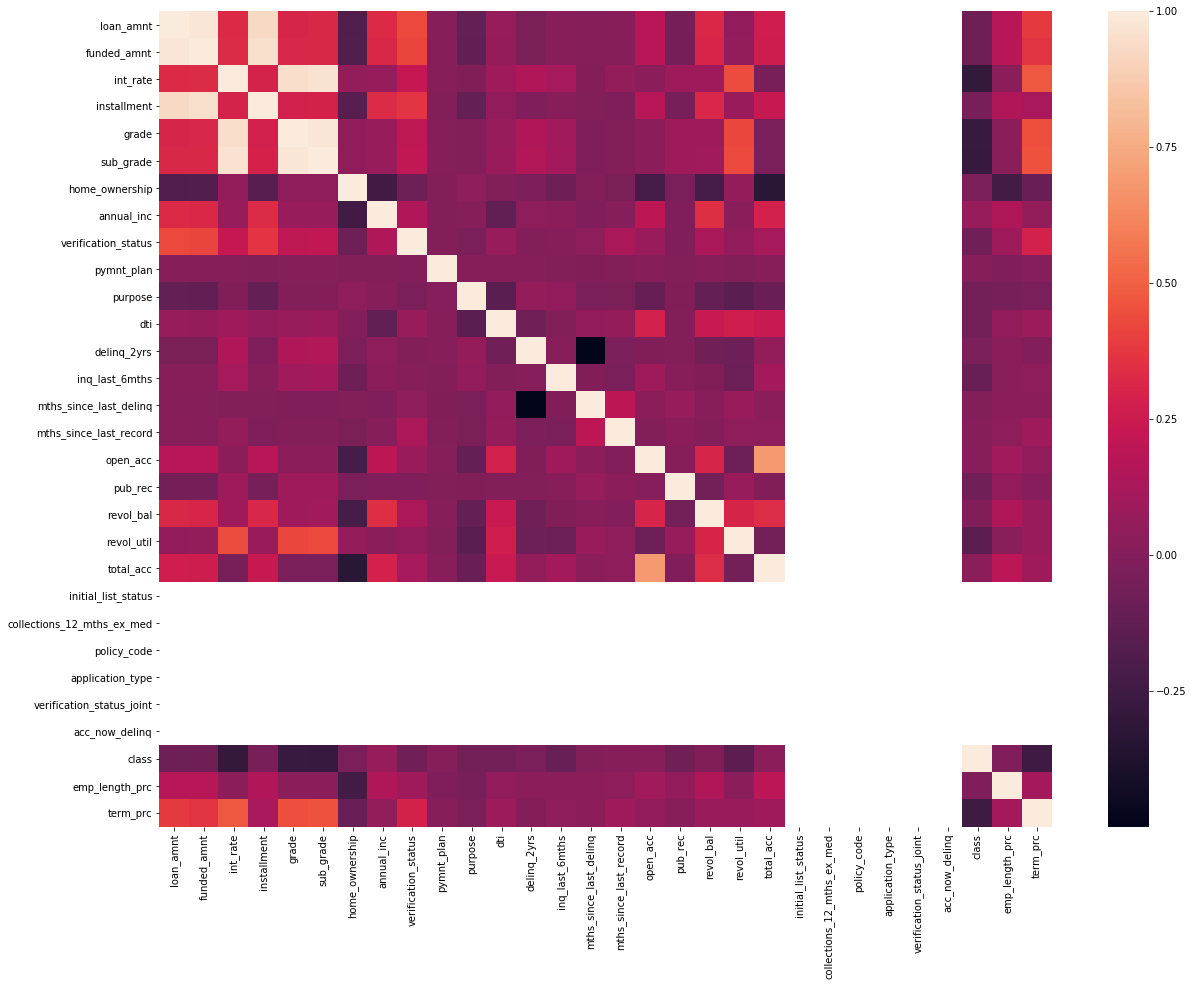

In [184]:
# Ayuda de: https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas
# https://datascience.stackexchange.com/questions/17540/make-seaborn-heatmap-bigger

# Se analiza la correlación entre los elementos del vector de características
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_f3.corr()
mapa = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
fig = mapa.get_figure()
fig.savefig('mapa_calor.jpg') 

term_prc - 1
int_rate - 2
subgrade y grade - Correlacionados, permanece Grade - 3
annual_inc - 4
purpose - 5
revol_util - 6 
revol_bal - 7
dti - 8
total_acc - 9
installment - 10

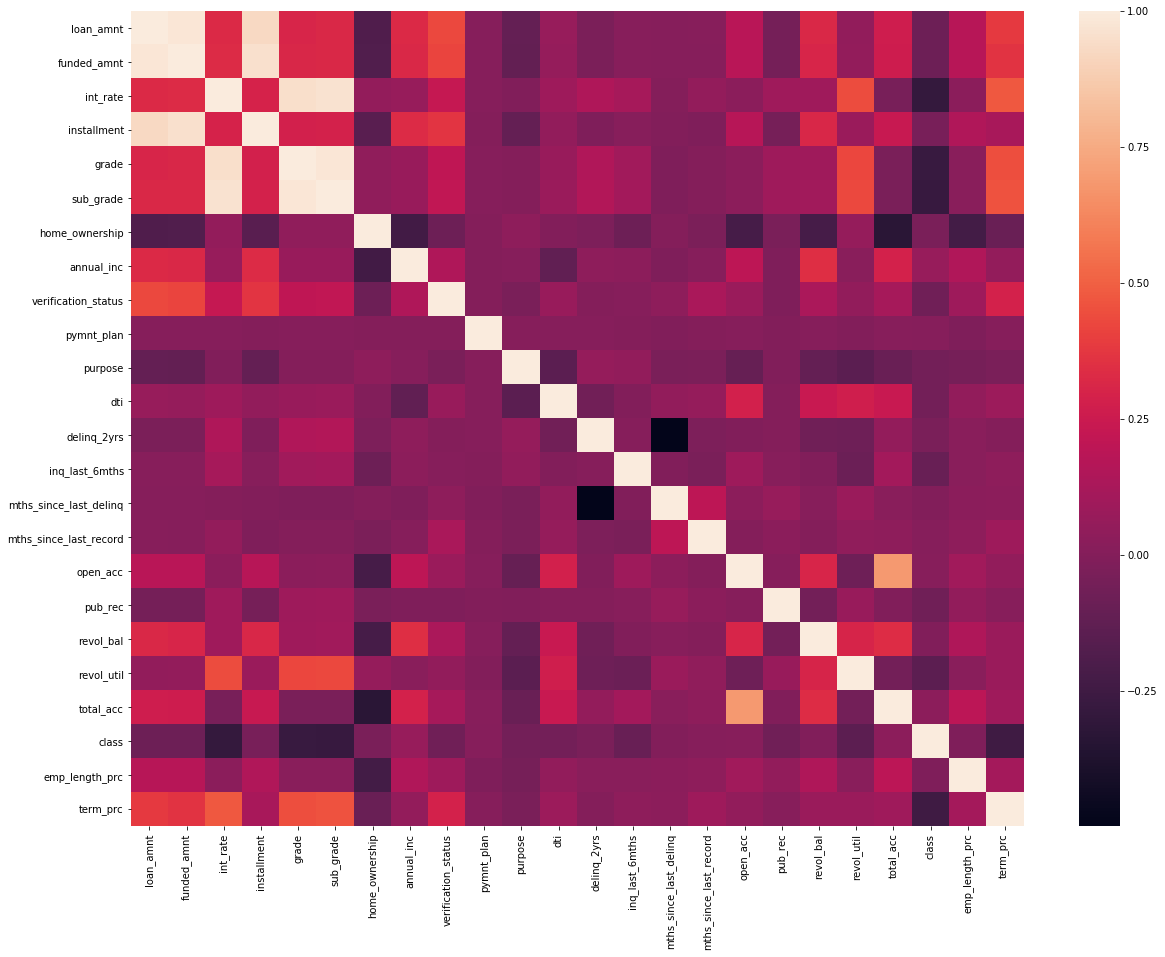

In [194]:
data_clear_corr = data_clear_f3.drop(columns=['initial_list_status','collections_12_mths_ex_med','policy_code',
                                              'application_type','verification_status_joint','acc_now_delinq'])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(20,15))
corr = data_clear_corr.corr()
mapa = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
fig = mapa.get_figure()
fig.savefig('mapa_calor.jpg') 

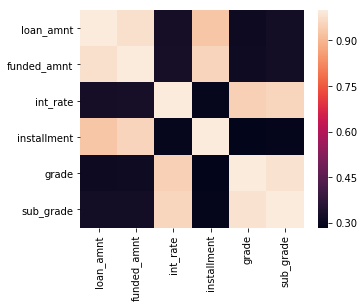

In [205]:
data_clear_corr_2 = data_clear_corr[['loan_amnt','funded_amnt','int_rate','installment','grade','sub_grade']]
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(5,4))
corr = data_clear_corr_2.corr()
mapa = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
fig = mapa.get_figure()
fig.savefig('mapa_calor_2.jpg')

# Clasificadores

Se utilizan las mismas características que identificaron los investigadores:

## Arbol de decision

### Caracteristicas autores

In [147]:
selected_columns = ['term_prc','loan_amnt','revol_util','grade','annual_inc','purpose','pymnt_plan','revol_bal','dti','mths_since_last_delinq']
data_set_paper = X_trainval[selected_columns] 
data_set_paper_test = X_test[selected_columns]

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import tree

model = tree.DecisionTreeClassifier(splitter='random',criterion='entropy')
pipe = Pipeline(steps=[('classification', model)])

p_max_depth = [2,4,6,8,10]
p_min_samples_leaf = [2,4,6]

param_grid = [
    {
        'classification__max_depth'   : p_max_depth,
        'classification__min_samples_leaf': p_min_samples_leaf
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=10, param_grid=param_grid, return_train_score=True, verbose=10)
grid.fit(data_set_paper,y_trainval)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6295566502463055, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6334975369458128, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score

[Parallel(n_jobs=10)]: Batch computation too fast (0.0575s.) Setting batch_size=6.


[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6528599605522682, total=   0.1s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6429980276134122, total=   0.1s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.632512315270936, total=   0.1s
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6364532019704433, total=   0.0s
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.626232741617357, total=   0.0s
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6390532544378699, total=   0.1s
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6229022704837117, total=   0.1s
[CV]  classi

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s


[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6334975369458128, total=   0.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6268509378084897, total=   0.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.6334975369458128, total=   0.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=4 .
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6282051282051282, to

[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6285714285714286, total=   0.1s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.6354679802955665, total=   0.1s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6426456071076012, total=   0.1s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6341222879684418, total=   0.0s
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6617357001972387, total=   0.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV]  classificatio

[Parallel(n_jobs=10)]: Done  26 tasks      | elapsed:    0.8s


[CV] classification__max_depth=8, classification__min_samples_leaf=6 .
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6390532544378699, total=   0.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6403940886699507, total=   0.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6275862068965518, total=   0.1s
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6357354392892399, total=   0.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=8, classification__min_samp

[CV]  classification__max_depth=10, classification__min_samples_leaf=2, score=0.645956607495069, total=   0.0s
[CV]  classification__max_depth=10, classification__min_samples_leaf=6, score=0.6331360946745562, total=   0.1s
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV]  classification__max_depth=10, classification__min_samples_leaf=2, score=0.6305418719211823, total=   0.0s
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.6226600985221675, total=   0.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6528599605522682, total=   0.0s
[CV]  classification__max_depth=10, classification__min_samples_leaf=6, score=0.6374384236453202, total=   0.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV]  classification__max_depth=10, classifica

[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classification', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'))]),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'classification__max_depth': [2, 4, 6, 8, 10], 'classification__min_samples_leaf': [2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [149]:
# Se obtienen los cross validation scores por cada una de las combinaciones de hiperparametros
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'])]

[({'classification__max_depth': 2, 'classification__min_samples_leaf': 2},
  0.6378698224852071),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 4},
  0.6389546351084813),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 6},
  0.6365877712031558),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 2},
  0.6383629191321499),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 4},
  0.6388560157790927),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 6},
  0.6398422090729783),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 2},
  0.6423076923076924),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 4},
  0.6398422090729783),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 6},
  0.6375739644970414),
 ({'classification__max_depth': 8, 'classification__min_samples_leaf': 2},
  0.6400394477317555),
 ({'classification__

In [154]:
# Obtener las desviaciones standar
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['std_test_score'])]

[({'classification__max_depth': 2, 'classification__min_samples_leaf': 2},
  0.011638829236979384),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 4},
  0.009956723975911127),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 6},
  0.01120031179574744),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 2},
  0.011131212928431248),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 4},
  0.01100907565724483),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 6},
  0.010153658831441823),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 2},
  0.009627171099654329),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 4},
  0.011171422576560732),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 6},
  0.013275349137774206),
 ({'classification__max_depth': 8, 'classification__min_samples_leaf': 2},
  0.009457109815203627),
 (

In [150]:
# Se identifica la mejor combinación de hiperparámetros
grid.best_params_

{'classification__max_depth': 6, 'classification__min_samples_leaf': 2}

In [158]:
# Fuente: documentacion Scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper.iloc[train_index], data_set_paper.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    CART = tree.DecisionTreeClassifier(criterion='entropy',splitter='random',max_depth=6, min_samples_leaf=4)
    CART = CART.fit(X_train,y_train)
    classifiers_lst.append(CART)
    y_pred = CART.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
std_score = np.std(scores_lst)
print(f'Accuracy promedio = {avg_score}')
print(f'Accuracy std = {std_score}')
best_class_tree = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_tree)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_tree[1].predict(data_set_paper_test)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   29    62    71 ... 10111 10119 10121]
TRAIN: [    0     1     2 ... 10136 10137 10139] TEST: [   15    20    23 ... 10129 10135 10138]
TRAIN: [    0     1     3 ... 10136 10138 10139] TEST: [    2     9    11 ... 10127 10131 10137]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   13    31    32 ... 10109 10113 10130]
TRAIN: [    0     1     2 ... 10136 10137 10138] TEST: [    4    10    17 ... 10122 10123 10139]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    3    18    19 ... 10097 10125 10126]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    8    66    91 ... 10117 10120 10133]
TRAIN: [    2     3     4 ... 10137 10138 10139] TEST: [    0     1     7 ... 10105 10108 10115]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    6    16    27 ... 10112 10118 10132]
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    5    14    21 ... 10128 10134 10136]


## Caracteristicas propias

Solo con propósito de experimentación.

In [118]:
selected_columns_2 = ['term_prc','int_rate','grade','annual_inc','purpose','revol_util','revol_bal','dti','total_acc','installment']
data_set = X_trainval[selected_columns] 
data_set_test = X_test[selected_columns]

In [159]:
# Busqueda en grilla para hiperparámetros
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import tree

model = tree.DecisionTreeClassifier(splitter='random',criterion='entropy')
pipe = Pipeline(steps=[('classification', model)])

p_max_depth = [2,4,6,8,10]
p_min_samples_leaf = [2,4,6]

param_grid = [
    {
        'classification__max_depth'   : p_max_depth,
        'classification__min_samples_leaf': p_min_samples_leaf
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=10, param_grid=param_grid, return_train_score=True, verbose=10)
grid.fit(data_set,y_trainval)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6344827586206897, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6315270935960591, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.625615763546798, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, cla

[Parallel(n_jobs=10)]: Batch computation too fast (0.0536s.) Setting batch_size=6.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.3s


[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6291913214990138, total=   0.2s
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.626232741617357, total=   0.1s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6597633136094675, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.625615763546798, total=   0.0s
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6315270935960591, total=   0.0s
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6410256410256411, total=   0.1s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6291913214990138, total=   0.0s
[CV]  classi

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.4s


[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6479289940828402, total=   0.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.626232741617357, total=   0.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV] classification__max_depth=6, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6321499013806706, total=   0.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.6354679802955665, total=   0.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.625615763546798, total=   0.1s
[CV] classification__

[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6403940886699507, total=   0.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV] classification__max_depth=6, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6538461538461539, total=   0.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6327739387956565, total=   0.1s
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.625615763546798, total=   0.1s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.626232741617357, total=   0.0s
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.6410256410256411, total=   0.0s
[CV] classification__max_depth=6, classification__mi

[Parallel(n_jobs=10)]: Done  26 tasks      | elapsed:    0.8s


[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6377097729516288, total=   0.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6400394477317555, total=   0.0s
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6423645320197044, total=   0.2s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV] classification__max_depth=8, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.631163708086785, total=   0.1s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6630434782608695, total=   0.0s
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6443349753694582, total=   0.0s
[CV] classification__max_depth=10, classification__

[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classification__max_depth=10, classification__min_samples_leaf=6, score=0.6305418719211823, total=   0.1s
[CV]  classification__max_depth=10, classification__min_samples_leaf=2, score=0.6341222879684418, total=   0.1s
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV]  classification__max_depth=8, classification__min_samples_leaf=4, score=0.6307996051332675, total=   0.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.626232741617357, total=   0.1s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.6344827586206897, total=   0.1s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classifica

[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:    1.6s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classification', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'))]),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'classification__max_depth': [2, 4, 6, 8, 10], 'classification__min_samples_leaf': [2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [120]:
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'])]

[({'classification__max_depth': 2, 'classification__min_samples_leaf': 2},
  0.6346153846153846),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 4},
  0.63767258382643),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 6},
  0.6346153846153846),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 2},
  0.6374753451676528),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 4},
  0.6358974358974359),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 6},
  0.6368836291913215),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 2},
  0.6424063116370808),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 4},
  0.6357988165680474),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 6},
  0.638560157790927),
 ({'classification__max_depth': 8, 'classification__min_samples_leaf': 2},
  0.6348126232741618),
 ({'classification__max

In [121]:
# Se identifica la mejor combinación de hiperparámetros
grid.best_params_

{'classification__max_depth': 6, 'classification__min_samples_leaf': 2}

# Red neuronal

In [160]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_set_paper)
data_set_paper_scl = pd.DataFrame(data=scaler.transform(data_set_paper),columns=data_set_paper.columns) 

# Aplicar el mismo escalamiento al set de pruebas
# scaler.fit(data_set_paper_test)
data_set_paper_test_scl = pd.DataFrame(data=scaler.transform(data_set_paper_test),columns=data_set_paper_test.columns)  

In [177]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-3)
pipe = Pipeline(steps=[('classification', model)])

p_learning_rate_init = [1e-3,1e-2,1e-1]
p_hidden_layer_sizes = [[8,4],[7]]

param_grid = [
    {
        'classification__learning_rate_init'   : p_learning_rate_init,
        'classification__hidden_layer_sizes': p_hidden_layer_sizes
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=10, param_grid=param_grid, return_train_score=True, verbose=10)
grid.fit(data_set_paper_scl,y_trainval)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001 
[CV]  classification__hidden_layer_size

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    6.0s


[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001, score=0.6577909270216963, total=   6.1s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.001, score=0.6403940886699507, total=   6.4s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6354679802955665, total=   5.7s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6206896551724138, total=   6.3s
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6469428007889546, total=   6.2s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   12.3s


[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6469428007889546, total=   6.4s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6351084812623274, total=   6.3s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6400394477317555, total=   6.5s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6347482724580454, total=   6.5s
[CV] classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.01, score=0.6597633136094675, total=   6.8

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   16.5s


[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1, score=0.6266009852216748, total=   4.8s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1, score=0.650887573964497, total=   5.0s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1, score=0.645320197044335, total=   5.2s
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1, score=0.6439842209072978, total=   5.0s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001 
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001 
[CV]  classification__hidden_layer_sizes=[8, 4], classification__learning_rate_init=0.1, score=0.6538461538461539, total=   5.0s
[CV] clas

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   18.4s


[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001, score=0.6344827586206897, total=   3.6s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001, score=0.6548323471400395, total=   3.2s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001, score=0.645320197044335, total=   3.7s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001, score=0.6528599605522682, total=   3.6s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.001, score=0.6463054187192119, total=   3.8s
[CV] classificati

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   23.6s


[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6472906403940887, total=   3.7s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6463054187192119, total=   3.9s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6351084812623274, total=   3.8s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6518737672583826, total=   3.7s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6607495069033531, total=   3.5s
[CV] classification__hidd

[Parallel(n_jobs=10)]: Done  48 out of  60 | elapsed:   25.5s remaining:    6.4s


[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6288252714708786, total=   3.9s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.01, score=0.6571146245059288, total=   3.8s
[CV] classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1 
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6354679802955665, total=   3.4s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6400394477317555, total=   3.3s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6315270935960591, total=   3.6s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6394088669950739, total=   3.6s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_r

[Parallel(n_jobs=10)]: Done  55 out of  60 | elapsed:   28.4s remaining:    2.6s


[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6637080867850098, total=   3.1s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.650887573964497, total=   3.2s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.646594274432379, total=   2.9s
[CV]  classification__hidden_layer_sizes=[7], classification__learning_rate_init=0.1, score=0.6610671936758893, total=   2.7s


[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:   28.8s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classification', MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'classification__learning_rate_init': [0.001, 0.01, 0.1], 'classification__hidden_layer_sizes': [[8, 4], [7]]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [178]:
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'])]

[({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.001},
  0.6456607495069033),
 ({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.01},
  0.6410256410256411),
 ({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.1},
  0.6448717948717949),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.001},
  0.6497041420118344),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.01},
  0.6464497041420119),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.1},
  0.6467455621301775)]

In [179]:
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['std_test_score'])]

[({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.001},
  0.011674672257396268),
 ({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.01},
  0.010354573354235952),
 ({'classification__hidden_layer_sizes': [8, 4],
   'classification__learning_rate_init': 0.1},
  0.01138367903275695),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.001},
  0.008328601493259492),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.01},
  0.010228880746434464),
 ({'classification__hidden_layer_sizes': [7],
   'classification__learning_rate_init': 0.1},
  0.010446040763114894)]

In [180]:
grid.best_params_

{'classification__hidden_layer_sizes': [7],
 'classification__learning_rate_init': 0.001}

In [183]:
# Multi-layer perceptron (MLP)
# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    MLP = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=([7]), learning_rate_init = 0.001, random_state=1)
    MLP = MLP.fit(X_train,y_train)
    classifiers_lst.append(MLP)
    y_pred = MLP.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
std_score = np.std(scores_lst)
print(f'Accuracy promedio = {avg_score}')
print(f'Accuracy std = {std_score}')
best_class_mlp = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_mlp)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_mlp[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    1     2     3 ... 10136 10137 10139] TEST: [    0    13    14 ... 10125 10128 10138]
Entrenando clasificador...
Score: 0.6282051282051282
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   21    41    45 ... 10116 10129 10132]
Entrenando clasificador...
Score: 0.6400394477317555
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    7    20    22 ... 10086 10110 10112]
Entrenando clasificador...
Score: 0.6518737672583826
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    9    17    43 ... 10126 10127 10135]
Entrenando clasificador...
Score: 0.6755424063116371
TRAIN: [    0     2     3 ... 10137 10138 10139] TEST: [    1    33    36 ... 10102 10107 10134]
Entrenando clasificador...
Score: 0.6725838264299803
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    4    10    11 ... 10130 10133 10136]
Entrenando clasificador...
Score: 0.6696252465483234
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [    3     5   

# Suppor Vector Machine 

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC(kernel='rbf')
pipe = Pipeline(steps=[('classification', model)])

p_C = [0.1,1,10]
p_kernel = ['rbf','linear','sigmoid']

param_grid = [
    {
        'classification__C'   : p_C,
        'classification__kernel' : p_kernel
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=10, param_grid=param_grid, return_train_score=True, verbose=10)
grid.fit(data_set_paper_scl,y_trainval)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV] classification__C=0.1, classification__kernel=rbf ...............
[CV]  classification__C=0.1, classification__kernel=rbf, score=0.6344827586206897, total=  18.4s
[CV] classification__C=0.1, classification__kernel=linear ............
[CV]  classification__C=0.1, classification__kernel=rbf, scor

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   24.9s


[CV]  classification__C=0.1, classification__kernel=rbf, score=0.6315270935960591, total=  19.4s
[CV] classification__C=0.1, classification__kernel=linear ............
[CV]  classification__C=0.1, classification__kernel=linear, score=0.626232741617357, total=   7.4s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6291913214990138, total=   7.6s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   35.5s


[CV]  classification__C=0.1, classification__kernel=linear, score=0.6203155818540433, total=   7.8s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6410256410256411, total=   7.6s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6315270935960591, total=   8.0s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6258637709772952, total=   7.8s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6571146245059288, total=   7.7s
[CV] classification__C=0.1, classification__kernel=sigmoid ...........
[CV]  classification__C=0.1, classification__kernel=linear, score=0.6344827586206897, total=   9.9s
[CV] classification__C=0.1, classification__k

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   55.8s


[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.5808678500986193, total=  15.8s
[CV] classification__C=1, classification__kernel=rbf .................
[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.5857988165680473, total=  15.0s
[CV] classification__C=1, classification__kernel=rbf .................
[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.5802955665024631, total=  17.0s
[CV] classification__C=1, classification__kernel=rbf .................
[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.6074950690335306, total=  16.8s
[CV] classification__C=1, classification__kernel=rbf .................
[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.5769230769230769, total=  16.7s
[CV]  classification__C=0.1, classification__kernel=sigmoid, score=0.6011846001974334, total=  15.1s
[CV] classification__C=1, classification__kernel=rbf .................
[CV] classification__C=1, classificatio

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.0min


[CV]  classification__C=1, classification__kernel=rbf, score=0.6344827586206897, total=  19.8s
[CV] classification__C=1, classification__kernel=linear ..............
[CV]  classification__C=1, classification__kernel=rbf, score=0.6305418719211823, total=  20.7s
[CV] classification__C=1, classification__kernel=linear ..............
[CV]  classification__C=1, classification__kernel=rbf, score=0.6364532019704433, total=  20.2s
[CV] classification__C=1, classification__kernel=linear ..............
[CV]  classification__C=1, classification__kernel=rbf, score=0.6400394477317555, total=  20.1s
[CV] classification__C=1, classification__kernel=linear ..............
[CV]  classification__C=1, classification__kernel=rbf, score=0.665680473372781, total=  19.9s
[CV] classification__C=1, classification__kernel=linear ..............
[CV]  classification__C=1, classification__kernel=rbf, score=0.6577909270216963, total=  19.9s
[CV] classification__C=1, classification__kernel=linear ..............
[CV] 

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  1.6min


[CV]  classification__C=1, classification__kernel=linear, score=0.625615763546798, total=  12.3s
[CV] classification__C=1, classification__kernel=sigmoid .............
[CV]  classification__C=1, classification__kernel=linear, score=0.6315270935960591, total=  12.9s
[CV] classification__C=1, classification__kernel=sigmoid .............
[CV]  classification__C=1, classification__kernel=linear, score=0.6291913214990138, total=  12.2s
[CV] classification__C=1, classification__kernel=sigmoid .............
[CV]  classification__C=1, classification__kernel=linear, score=0.6203155818540433, total=  12.3s
[CV] classification__C=1, classification__kernel=sigmoid .............
[CV]  classification__C=1, classification__kernel=linear, score=0.6518737672583826, total=  12.6s
[CV] classification__C=1, classification__kernel=sigmoid .............
[CV]  classification__C=1, classification__kernel=linear, score=0.6410256410256411, total=  12.4s
[CV] classification__C=1, classification__kernel=sigmoid .

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.9min


[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5635467980295567, total=  12.0s
[CV] classification__C=10, classification__kernel=rbf ................
[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5513833992094862, total=   9.3s
[CV] classification__C=10, classification__kernel=rbf ................
[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5636722606120435, total=  10.2s
[CV] classification__C=10, classification__kernel=rbf ................
[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5690335305719921, total=  13.4s
[CV] classification__C=10, classification__kernel=rbf ................
[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5739644970414202, total=  14.2s
[CV] classification__C=10, classification__kernel=rbf ................
[CV]  classification__C=1, classification__kernel=sigmoid, score=0.5473372781065089, total=  15.2s
[CV] classification__C=10, classification__kernel=r

[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  2.4min


[CV]  classification__C=10, classification__kernel=rbf, score=0.6528599605522682, total=  27.0s
[CV] classification__C=10, classification__kernel=linear .............
[CV]  classification__C=10, classification__kernel=rbf, score=0.6479289940828402, total=  26.0s
[CV] classification__C=10, classification__kernel=linear .............
[CV]  classification__C=10, classification__kernel=rbf, score=0.645956607495069, total=  25.2s
[CV] classification__C=10, classification__kernel=linear .............
[CV]  classification__C=10, classification__kernel=rbf, score=0.6426456071076012, total=  26.0s
[CV] classification__C=10, classification__kernel=linear .............
[CV]  classification__C=10, classification__kernel=rbf, score=0.6462450592885376, total=  24.9s
[CV] classification__C=10, classification__kernel=linear .............
[CV]  classification__C=10, classification__kernel=linear, score=0.6344827586206897, total=  29.6s
[CV] classification__C=10, classification__kernel=sigmoid .........

[Parallel(n_jobs=10)]: Done  81 out of  90 | elapsed:  3.2min remaining:   21.1s


[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5625615763546798, total=  13.3s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5749506903353058, total=  10.7s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5660749506903353, total=  13.6s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5557749259624877, total=   9.2s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5625615763546798, total=  17.4s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5473372781065089, total=  14.1s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5453648915187377, total=  15.2s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5424901185770751, total=   9.9s
[CV]  classification__C=10, classification__kernel=sigmoid, score=0.5581854043392505, total=  19.6s


[Parallel(n_jobs=10)]: Done  90 out of  90 | elapsed:  3.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classification', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'classification__C': [0.1, 1, 10], 'classification__kernel': ['rbf', 'linear', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [172]:
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'])]

[({'classification__C': 0.1, 'classification__kernel': 'rbf'},
  0.6388560157790927),
 ({'classification__C': 0.1, 'classification__kernel': 'linear'},
  0.6343195266272189),
 ({'classification__C': 0.1, 'classification__kernel': 'sigmoid'},
  0.5894477317554241),
 ({'classification__C': 1, 'classification__kernel': 'rbf'},
  0.6448717948717949),
 ({'classification__C': 1, 'classification__kernel': 'linear'},
  0.6343195266272189),
 ({'classification__C': 1, 'classification__kernel': 'sigmoid'},
  0.5620315581854043),
 ({'classification__C': 10, 'classification__kernel': 'rbf'},
  0.6419132149901381),
 ({'classification__C': 10, 'classification__kernel': 'linear'},
  0.6343195266272189),
 ({'classification__C': 10, 'classification__kernel': 'sigmoid'},
  0.5587771203155818)]

In [173]:
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['std_test_score'])]

[({'classification__C': 0.1, 'classification__kernel': 'rbf'},
  0.012828485461614062),
 ({'classification__C': 0.1, 'classification__kernel': 'linear'},
  0.011465650969449364),
 ({'classification__C': 0.1, 'classification__kernel': 'sigmoid'},
  0.01019404755973226),
 ({'classification__C': 1, 'classification__kernel': 'rbf'},
  0.012361201938198629),
 ({'classification__C': 1, 'classification__kernel': 'linear'},
  0.011465650969449364),
 ({'classification__C': 1, 'classification__kernel': 'sigmoid'},
  0.008065507267102298),
 ({'classification__C': 10, 'classification__kernel': 'rbf'},
  0.011085467194190013),
 ({'classification__C': 10, 'classification__kernel': 'linear'},
  0.011465650969449364),
 ({'classification__C': 10, 'classification__kernel': 'sigmoid'},
  0.010557049275086751)]

In [174]:
grid.best_params_

{'classification__C': 1, 'classification__kernel': 'rbf'}

In [175]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

kf = KFold(n_splits=10,shuffle=True)
classifiers_lst = []
scores_lst = []
print('Ejecutando validacion cruzada')
for train_index, test_index in kf.split(data_set_paper_scl):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = data_set_paper_scl.iloc[train_index], data_set_paper_scl.iloc[test_index]
    y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[test_index]
    print("Entrenando clasificador...")
    SVC_model = SVC(C=1,kernel='rbf')
    SVC_model = SVC_model.fit(X_train,y_train)
    classifiers_lst.append(SVC_model)
    y_pred = SVC_model.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    print(f'Score: {score}')
    scores_lst.append(score)
#avg_score = cross_val_score(tree.DecisionTreeClassifier(),data_set_paper,y_trainval,cv=10).mean()
avg_score = np.mean(scores_lst)
std_score = np.std(scores_lst)
print(f'Accuracy promedio = {avg_score}')
print(f'Accuracy std = {std_score}')
best_class_svc = sorted(zip(scores_lst,classifiers_lst),key=(lambda x: x[0]),reverse=True)[0]
print('Mejor clasificador encontrado:')
print(best_class_svc)
print('Probando el mejor clasificador con el set de prueba...')
y_test_pred = best_class_svc[1].predict(data_set_paper_test_scl)
test_score = accuracy_score(y_test,y_test_pred)
print(f'El accuracy con el set de prueba es {round(test_score,4)}')

Ejecutando validacion cruzada
TRAIN: [    0     3     5 ... 10137 10138 10139] TEST: [    1     2     4 ... 10127 10134 10136]
Entrenando clasificador...
Score: 0.6518737672583826
TRAIN: [    0     1     2 ... 10136 10137 10138] TEST: [   17    25    31 ... 10109 10133 10139]
Entrenando clasificador...
Score: 0.6479289940828402
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   28    29    41 ... 10085 10116 10122]
Entrenando clasificador...
Score: 0.6380670611439843
TRAIN: [    1     2     3 ... 10137 10138 10139] TEST: [    0     5     8 ... 10102 10106 10126]
Entrenando clasificador...
Score: 0.6745562130177515
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   12    23    34 ... 10083 10095 10108]
Entrenando clasificador...
Score: 0.6528599605522682
TRAIN: [    0     1     2 ... 10137 10138 10139] TEST: [   11    14    22 ... 10113 10118 10129]
Entrenando clasificador...
Score: 0.6449704142011834
TRAIN: [    0     1     2 ... 10136 10137 10139] TEST: [    3    10   

# Ejemplo de uso de GridSearchCV

Para esto se asume todo el preprocesamiento terminado y que se tiene un X_trainval y y_trainval

## Opcion 1: Reducir con Random Forest antes del clasificador

In [206]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

tree_model = tree.DecisionTreeClassifier(splitter='random',criterion='entropy')
pipe = Pipeline(steps=[('feature_selection',SelectFromModel(RandomForestClassifier(n_estimators=10))),
                       ('classification', tree_model)])

p_max_depth = [2,4,6,8,10]
p_min_samples_leaf = [2,4,6]

param_grid = [
    {
        'classification__max_depth'   : p_max_depth,
        'classification__min_samples_leaf': p_min_samples_leaf
    }
]

grid = GridSearchCV(pipe, cv=10, n_jobs=10, param_grid=param_grid, return_train_score=True, verbose=10)
grid.fit(X_trainval,y_trainval)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV] classification__max_depth=2, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=2, score=0.6344827586206897, total=   0.8s
[CV] classification__max_depth=2, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=2, classifica

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.3s


[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6344827586206897, total=   0.9s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6187192118226601, total=   1.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6197044334975369, total=   0.9s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.5897435897435898, total=   0.9s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .


[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.0s


[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.5828402366863905, total=   0.9s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6094674556213018, total=   1.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.5873642645607108, total=   0.9s
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.5968379446640316, total=   0.9s
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.6410256410256411, total=   1.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=4, score=0.626232741617357, total=   1.0s
[CV] classification__max_depth=2, classification__min_samples_leaf=6 .
[CV] classification__max_depth=2, classification__m

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    2.9s


[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.6291913214990138, total=   0.9s
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.6203155818540433, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.6045364891518737, total=   0.9s
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.626232741617357, total=   0.9s
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.6410256410256411, total=   0.9s
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV] classification__max_depth=4, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=2, classification__min_samples_leaf=6, score=0.590325765054

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.4s


[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6128078817733991, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6108374384236454, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6413793103448275, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.6410256410256411, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.621301775147929, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=2, score=0.617357001972

[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    5.0s


[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6331360946745562, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6420118343195266, total=   0.9s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.626232741617357, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6370808678500987, total=   0.9s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.6321499013806706, total=   1.0s
[CV] classification__max_depth=4, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=4, score=0.626850937808

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    6.0s


[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6380670611439843, total=   0.9s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6055226824457594, total=   0.9s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6242603550295858, total=   0.9s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6321499013806706, total=   0.9s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.6327739387956565, total=   0.9s
[CV] classification__max_depth=6, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=4, classification__min_samples_leaf=6, score=0.61561264822

[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    7.3s


[CV] classification__max_depth=6, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=2, score=0.5988142292490118, total=   1.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6078817733990147, total=   1.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6187192118226601, total=   1.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6206896551724138, total=   1.1s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=4, score=0.6173570019723866, total=   1.0s
[CV] classification__max_depth=6, classification__min_samples_leaf=6 .
[CV]  classificatio

[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    8.5s


[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6078817733990147, total=   1.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6137931034482759, total=   1.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6344827586206897, total=   1.1s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6173570019723866, total=   1.1s
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.6074950690335306, total=   1.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV] classification__max_depth=8, classification__min_samples_leaf=2 .
[CV]  classification__max_depth=6, classification__min_samples_leaf=6, score=0.62426035502

[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   10.5s


[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6489151873767258, total=   1.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6222879684418146, total=   1.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6219151036525172, total=   1.0s
[CV]  classification__max_depth=8, classification__min_samples_leaf=2, score=0.6106719367588933, total=   1.0s
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV] classification__max_depth=8, classification__min_samples_leaf=4 .
[CV]  classification__max_depth=8, classification__min_samples_leaf=4, score=0.645320197044335, total=   0.9s
[CV] classification__max_depth=8, classification__min_samples_leaf=6 .
[CV]  classification__max_depth=8, classification__min_samples_leaf=4, score=0.596059113300

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   11.7s


[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6128078817733991, total=   0.9s
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6157635467980296, total=   1.0s
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6108374384236454, total=   1.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6489151873767258, total=   0.9s
[CV] classification__max_depth=10, classification__min_samples_leaf=2 
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.6439842209072978, total=   1.0s
[CV]  classification__max_depth=8, classification__min_samples_leaf=6, score=0.626232741617357, total=   1.1s
[CV] classification__max_depth=10, classification__

[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   13.5s


[CV]  classification__max_depth=10, classification__min_samples_leaf=2, score=0.6195652173913043, total=   0.9s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV]  classification__max_depth=10, classification__min_samples_leaf=2, score=0.5932872655478776, total=   0.9s
[CV] classification__max_depth=10, classification__min_samples_leaf=4 
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.6088669950738916, total=   1.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.6321499013806706, total=   0.9s
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.5891625615763547, total=   1.0s
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV] classification__max_depth=10, classification__min_samples_leaf=6 
[CV]  classification__max_depth=10, classification__min_samples_leaf=4, score=0.60749

[Parallel(n_jobs=10)]: Done 147 out of 150 | elapsed:   15.5s remaining:    0.3s
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed:   15.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min...    min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'))]),
       fit_params=None, iid=True, n_jobs=10,
       param_grid=[{'classification__max_depth': [2, 4, 6, 8, 10], 'classification__min_samples_leaf': [2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [207]:
# Obtener los valores de hiperparámetros
grid.best_params_

{'classification__max_depth': 4, 'classification__min_samples_leaf': 4}

In [210]:
# Obtener el score (buscar la entrada donde max_depth=4 y min_samples_leaf=4 ). Resultado: 0.6340236686390532
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['mean_test_score'])]

[({'classification__max_depth': 2, 'classification__min_samples_leaf': 2},
  0.6289940828402367),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 4},
  0.6106508875739645),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 6},
  0.619723865877712),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 2},
  0.6212031558185405),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 4},
  0.6340236686390532),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 6},
  0.6284023668639053),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 2},
  0.6206114398422091),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 4},
  0.6189349112426036),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 6},
  0.6171597633136094),
 ({'classification__max_depth': 8, 'classification__min_samples_leaf': 2},
  0.6230769230769231),
 ({'classification__m

In [211]:
# Obtener la desviacion standard del score (buscar la entrada donde max_depth=4 y min_samples_leaf=4 ). Resultado: 0.009560394344234476
[x for x in zip(grid.cv_results_['params'],grid.cv_results_['std_test_score'])]

[({'classification__max_depth': 2, 'classification__min_samples_leaf': 2},
  0.009467979642222905),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 4},
  0.01955824280039014),
 ({'classification__max_depth': 2, 'classification__min_samples_leaf': 6},
  0.013793277642576412),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 2},
  0.011032944721388105),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 4},
  0.009560394344234476),
 ({'classification__max_depth': 4, 'classification__min_samples_leaf': 6},
  0.009986741337161431),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 2},
  0.01743237083054161),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 4},
  0.007828340687818276),
 ({'classification__max_depth': 6, 'classification__min_samples_leaf': 6},
  0.008425365792716919),
 ({'classification__max_depth': 8, 'classification__min_samples_leaf': 2},
  0.01587382956046838),
 ({

In [230]:
# Las caracteristicas con valore en True son relevantes para el modelo
new_feature_list=[x[0] for x in zip(X_trainval.columns,grid.best_estimator_.named_steps['feature_selection'].get_support()) if x[1]==True ]

In [239]:
# Se reduce el set a las caracteristicas encontradas
X_trainval_red = X_trainval[new_feature_list]
X_test_red = X_test[new_feature_list]

In [234]:
# Se entrena un arbol con todo el set de entrenamiento. Se usa el valor de hiperparametros encontrados.
tree_model = tree.DecisionTreeClassifier(splitter='random',criterion='entropy',max_depth=4,min_samples_leaf= 4)
tree_model = tree_model.fit(X_trainval_red,y_trainval)

In [237]:
# Se obtienen las importancias
importance_list = sorted(zip(X_trainval_red.columns,tree_model.feature_importances_),key=(lambda x:x[1]),reverse=True)
importance_list

In [238]:
importance_list 

[('sub_grade', 0.9045428227360657),
 ('int_rate', 0.05863126760058536),
 ('funded_amnt', 0.013721006336516307),
 ('annual_inc', 0.0093113768559049),
 ('installment', 0.005684458486888103),
 ('dti', 0.004956431685542128),
 ('total_acc', 0.0031526362984976688),
 ('loan_amnt', 0.0),
 ('purpose', 0.0),
 ('mths_since_last_delinq', 0.0),
 ('open_acc', 0.0),
 ('revol_bal', 0.0),
 ('revol_util', 0.0),
 ('emp_length_prc', 0.0)]

In [242]:
# Obtener la precision
from sklearn.metrics import precision_score
y_test_pred = tree_model.predict(X_test_red)
precision_score(y_test, y_test_pred,average='micro') 

0.5992110453648916

## Opcion 2: Enviar el conjunto completo

In [244]:
tree_model_2 = tree.DecisionTreeClassifier(splitter='random',criterion='entropy',max_depth=4,min_samples_leaf= 4)
tree_model_2 = tree_model_2.fit(X_trainval,y_trainval)
y_test_pred_2 = tree_model_2.predict(X_test)
precision_score(y_test, y_test_pred_2,average='micro') 

0.6220907297830375

In [245]:
importance_list_2 = sorted(zip(X_trainval.columns,tree_model_2.feature_importances_),key=(lambda x:x[1]),reverse=True)
importance_list_2

[('term_prc', 0.6118419386770434),
 ('grade', 0.25121441644186254),
 ('sub_grade', 0.06755749409606568),
 ('annual_inc', 0.017175469469993866),
 ('revol_util', 0.012026801304696333),
 ('open_acc', 0.010024446604784718),
 ('int_rate', 0.008907423721127834),
 ('mths_since_last_record', 0.0073543552028750726),
 ('home_ownership', 0.007321688448358915),
 ('pub_rec', 0.006575966033191748),
 ('loan_amnt', 0.0),
 ('funded_amnt', 0.0),
 ('installment', 0.0),
 ('verification_status', 0.0),
 ('pymnt_plan', 0.0),
 ('purpose', 0.0),
 ('dti', 0.0),
 ('delinq_2yrs', 0.0),
 ('inq_last_6mths', 0.0),
 ('mths_since_last_delinq', 0.0),
 ('revol_bal', 0.0),
 ('total_acc', 0.0),
 ('initial_list_status', 0.0),
 ('collections_12_mths_ex_med', 0.0),
 ('policy_code', 0.0),
 ('application_type', 0.0),
 ('verification_status_joint', 0.0),
 ('acc_now_delinq', 0.0),
 ('emp_length_prc', 0.0)]

## Conclusion

En vista que la precisión obtenida con el clasificador entrenado recibiendo todas las caracteristicas fue mayor, se utiliza el vector de importancias que genera este modelo.